<a href="https://colab.research.google.com/github/ar5entum/glaucoma-detection/blob/main/detection_of_glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of Glaucoma

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import torch.cuda as cuda
import torchvision.models as models

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
from PIL import Image
import matplotlib.patches as patches

In [ ]:
def get_box_from_json(path):
  data = json.load(open(path, 'r'))
  points = None
  for shape in data["shapes"]:
    if shape["label"] == "discLoc":
      points = shape["points"]
      break
  np.array(data["shapes"][2]["points"])[:, 1]
  x_1 = int(min(i for i in np.array(points)[:, 1]))
  x_2 = int(max(i for i in np.array(points)[:, 1]))
  y_1 = int(min(i for i in np.array(points)[:, 0]))
  y_2 = int(max(i for i in np.array(points)[:, 0]))
  return x_1, y_1, x_2, y_2

In [ ]:
def display_image_with_annot(path):
  img = Image.open(path)
  data = json.load(open(path[:-3] + "json", 'r'))
  fig, ax = plt.subplots()
  ax.imshow(img)
  for shape in data['shapes']:
      points = shape['points']
      label = shape['label']

      if len(points) > 2:
          polygon = patches.Polygon(points, closed=True, fill=False)
          ax.add_patch(polygon)
      else:
          x, y = zip(*points)
          ax.plot(x, y, color=data['lineColor'][:3])

      ax.text(points[0][0], points[0][1], label, fontsize=8)

  # Set axis limits based on image dimensions
  ax.set_xlim(0, 3000)
  ax.set_ylim(0, 2423)

  # Show the plot
  plt.show()

In [ ]:
# TODO
def coords_to_yolo_coords(x_1, y_1, x_2, y_2):
  box_width = abs(x_1 - x_2)
  box_height = abs(x_2 - y_2)
  center_x = int((x_1 + x_2) * 0.5)
  center_y = int((y_1 + y_2) * 0.5)
  return box_width, box_height, center_x, center_y

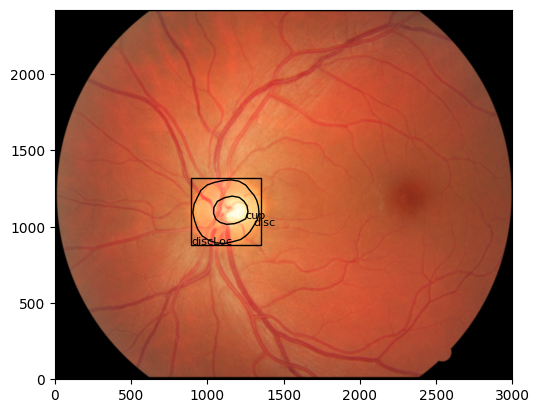

(880, 894, 1318, 1349)


In [ ]:
display_image_with_annot("/content/drive/MyDrive/G1020/Images/image_3.jpg")
print(get_box_from_json('/content/drive/MyDrive/G1020/Images/image_3.json'))

In [ ]:
csv = pd.read_csv('/content/drive/MyDrive/G1020/G1020.csv')
csv.head()

,imageID,binaryLabels
0,image_0.jpg,0
1,image_1.jpg,0
2,image_3.jpg,0
3,image_4.jpg,0
4,image_5.jpg,0


In [ ]:
root_dir = "/content/drive/MyDrive/G1020/Images/"
json_files = [f for f in os.listdir(root_dir) if f.endswith('.json')]
missing_count = 0
json_data = []
for filename in csv["imageID"]:
  filename = filename[:-3] + "json"
  try:
    json_data.append(get_box_from_json(os.path.join(root_dir, filename)))
  except:
    missing_count+=1
    json_data.append(np.nan)
print("Number of missing values: ", missing_count)
csv["coord"] = json_data

Number of missing values:  241


In [ ]:
csv = csv.dropna()
csv = csv.sample(frac=1).reset_index(drop=True)
csv

,imageID,binaryLabels,coord
0,image_2999.jpg,0,"(769, 1209, 1275, 1698)"
1,image_470.jpg,0,"(816, 2447, 1428, 2911)"
2,image_1742.jpg,1,"(884, 2283, 1375, 2672)"
3,image_709.jpg,0,"(619, 645, 1140, 1113)"
4,image_1935.jpg,1,"(624, 948, 1090, 1433)"
...,...,...,...
774,image_2355.jpg,0,"(969, 253, 1448, 674)"
775,image_699.jpg,0,"(857, 206, 1139, 462)"
776,image_1426.jpg,0,"(690, 1545, 1205, 2006)"
777,image_879.jpg,0,"(580, 313, 990, 696)"


In [ ]:
csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   imageID       779 non-null    object
 1   binaryLabels  779 non-null    int64 
 2   coord         779 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.4+ KB


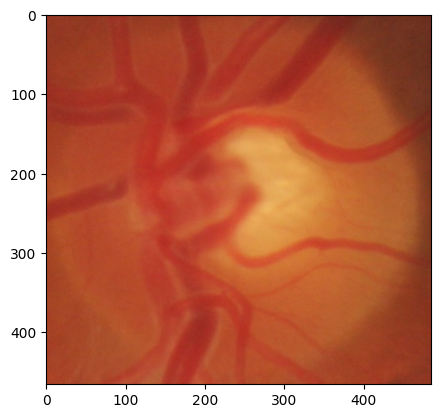

In [ ]:
img = np.array(Image.open(root_dir + csv["imageID"][4]))
x_1, y_1, x_2, y_2 = list(csv["coord"][4])
plt.imshow(img[x_1: x_2, y_1: y_2])

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, df, root_dir, transform=None, train=True, split_ratio=0.9):
    self.train = train

    split_idx = int(len(df) * split_ratio)

    if self.train:
      df = df[:split_idx]
    else:
      df = df[split_idx:]

    self.frame = df
    self.transform = transform
    self.root_dir = root_dir
  def __len__(self):
    return len(self.frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = self.frame.iloc[idx, 0]
    x_1, y_1, x_2, y_2 = list(self.frame.iloc[idx, 2])
    image = Image.open(self.root_dir + img_name)
    # image = Image.fromarray(np.array(Image.open(self.root_dir + img_name))[x_1: x_2, y_1: y_2])

    if self.transform:
      image = self.transform(image)

    label = int(self.frame.iloc[idx, 1])

    return image, label

In [ ]:
T = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((.1307), (.3081)),
])

In [ ]:
training_data = CustomDataset(csv, root_dir,  transform = T, train=True)
testing_data = CustomDataset(csv, root_dir, transform = T, train=False)

In [ ]:
batch_size = 32
train_dl = DataLoader(training_data, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(testing_data, batch_size = batch_size, shuffle = True)

In [ ]:
for i, (image, targets) in enumerate(training_data):
    print(i, np.array(image).shape, targets)

    if i == 2:
        break

0 (3, 256, 256) 0
1 (3, 256, 256) 0
2 (3, 256, 256) 1


0


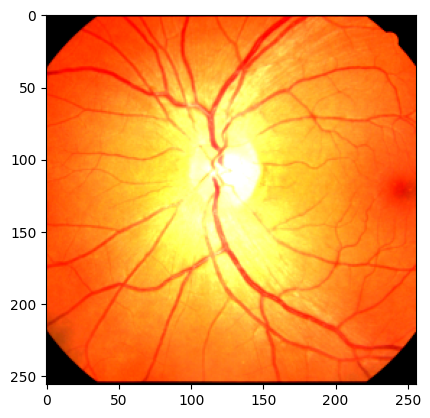

In [ ]:
plt.imshow(training_data[0][0].permute(1,2,0))
print(training_data[0][1])

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Max pooling layers
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 128)

        # Output layer
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        # Flatten the feature maps
        x = x.view(-1, 128 * 32 * 32)

        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=True)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, training=True)
        x = self.fc3(x)

        return x

In [ ]:
net = Net()

if cuda.is_available():
    net = net.cuda()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(net.parameters())

In [ ]:
num_epoch = 30

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epoch):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    net.train()

    for i, (items, classes) in enumerate(train_dl):
        items = Variable(items)
        classes = Variable(classes)

        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()

        optimizer.zero_grad()
        outputs = net(items)
        loss = criterion(outputs.squeeze(0), classes)
        iter_loss += loss.data
        loss.backward()
        optimizer.step()

        _,predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    train_loss.append((iter_loss/iterations).cpu())
    train_accuracy.append((100 * correct / len(train_dl.dataset)).cpu())

    loss = 0
    correct = 0
    iterations = 0

    net.eval()

    for i, (items, classes) in enumerate(test_dl):
        items = Variable(items)
        classes = Variable(classes)
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()

        outputs = net(items)      # Do the forward pass
        loss += criterion(outputs, classes).data # Calculate the loss

        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()

        iterations += 1

    # Record the validation loss
    test_loss.append((loss/iterations).cpu())
    # Record the validation accuracy
    test_accuracy.append((correct / len(test_dl.dataset) * 100.0).cpu())


    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epoch, train_loss[-1], train_accuracy[-1],
             test_loss[-1], test_accuracy[-1]))

Epoch 1/30, Tr Loss: 0.6729, Tr Acc: 67.0471, Val Loss: 0.6395, Val Acc: 70.5128
Epoch 2/30, Tr Loss: 0.6400, Tr Acc: 70.0428, Val Loss: 0.5952, Val Acc: 71.7949
Epoch 3/30, Tr Loss: 0.6123, Tr Acc: 70.3281, Val Loss: 0.5703, Val Acc: 71.7949
Epoch 4/30, Tr Loss: 0.6121, Tr Acc: 70.4708, Val Loss: 0.6289, Val Acc: 71.7949
Epoch 5/30, Tr Loss: 0.6226, Tr Acc: 70.6134, Val Loss: 0.6016, Val Acc: 71.7949
Epoch 6/30, Tr Loss: 0.6040, Tr Acc: 70.4708, Val Loss: 0.5931, Val Acc: 71.7949
Epoch 7/30, Tr Loss: 0.6195, Tr Acc: 70.4708, Val Loss: 0.6050, Val Acc: 71.7949
Epoch 8/30, Tr Loss: 0.6053, Tr Acc: 70.6134, Val Loss: 0.6412, Val Acc: 71.7949
Epoch 9/30, Tr Loss: 0.6068, Tr Acc: 70.3281, Val Loss: 0.6186, Val Acc: 71.7949
Epoch 10/30, Tr Loss: 0.6055, Tr Acc: 70.6134, Val Loss: 0.6406, Val Acc: 71.7949
Epoch 11/30, Tr Loss: 0.5945, Tr Acc: 71.1840, Val Loss: 0.6036, Val Acc: 74.3590
Epoch 12/30, Tr Loss: 0.6074, Tr Acc: 70.7561, Val Loss: 0.6738, Val Acc: 71.7949


KeyboardInterrupt: ignored